<a href="https://colab.research.google.com/github/Ashraf-Saleheen/For-Upwork/blob/main/MSFT_Stock_Price_Prediction_Using_LSTM_%26_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the MSFT data from Yahoo finance

In [ ]:
import yfinance as yf

# Download MSFT data
msft = yf.download("MSFT", start="2020-01-01", end="2025-01-01")

# Save to CSV
msft.to_csv("msft_data.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("msft_data.csv")
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,153.0423126220703,153.14712365624922,150.86035596005522,151.28912308572728,22622100
3,2020-01-03,151.13662719726562,152.40388225400224,150.60304918156822,150.85079221664952,21116200
4,2020-01-06,151.52732849121094,151.59403303057528,149.1262122356397,149.66932792275708,20813700


### Importing necessary libraries

In [ ]:
import numpy as np
import pandas_datareader as web
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("msft_data.csv")
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,153.0423126220703,153.14712365624922,150.86035596005522,151.28912308572728,22622100
3,2020-01-03,151.13662719726562,152.40388225400224,150.60304918156822,150.85079221664952,21116200
4,2020-01-06,151.52732849121094,151.59403303057528,149.1262122356397,149.66932792275708,20813700


### Confirming Index Type

In [ ]:
print(df.index)
print(df.index.dtype)


Index(['Ticker', 'Date', '2020-01-02', '2020-01-03', '2020-01-06',
       '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
       ...
       '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23',
       '2024-12-24', '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31'],
      dtype='object', name='Price', length=1260)
object


### Checking the column name

In [ ]:
print(df.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


### our CSV is not in the standard time-series format where each row is a date with columns like 'Open', 'High', 'Close', etc.

Instead, our CSV has:

Rows = stocks (like 'MSFT')

Columns = dates ('2020-01-02', '2020-01-03', ..., '2024-12-31')

So it’s in a wide format, not a long format — that’s why df['Close'] and df.plot() are failing.

To Fix we do the following.

### Ensuring index is datetime and dropping rows with invalid datetime or missing data.

In [ ]:
# Ensure index is datetime
df.index = pd.to_datetime(df.index, errors='coerce')

# Drop rows with invalid datetime or missing data
df = df[df.index.notna()]
df = df.dropna(subset=['Close'])

In [ ]:
df.shape

(1258, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Close   1258 non-null   object
 1   High    1258 non-null   object
 2   Low     1258 non-null   object
 3   Open    1258 non-null   object
 4   Volume  1258 non-null   object
dtypes: object(5)
memory usage: 59.0+ KB


In [ ]:
df.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Close   1258 non-null   object
 1   High    1258 non-null   object
 2   Low     1258 non-null   object
 3   Open    1258 non-null   object
 4   Volume  1258 non-null   object
dtypes: object(5)
memory usage: 59.0+ KB


### Visualizing the closing price

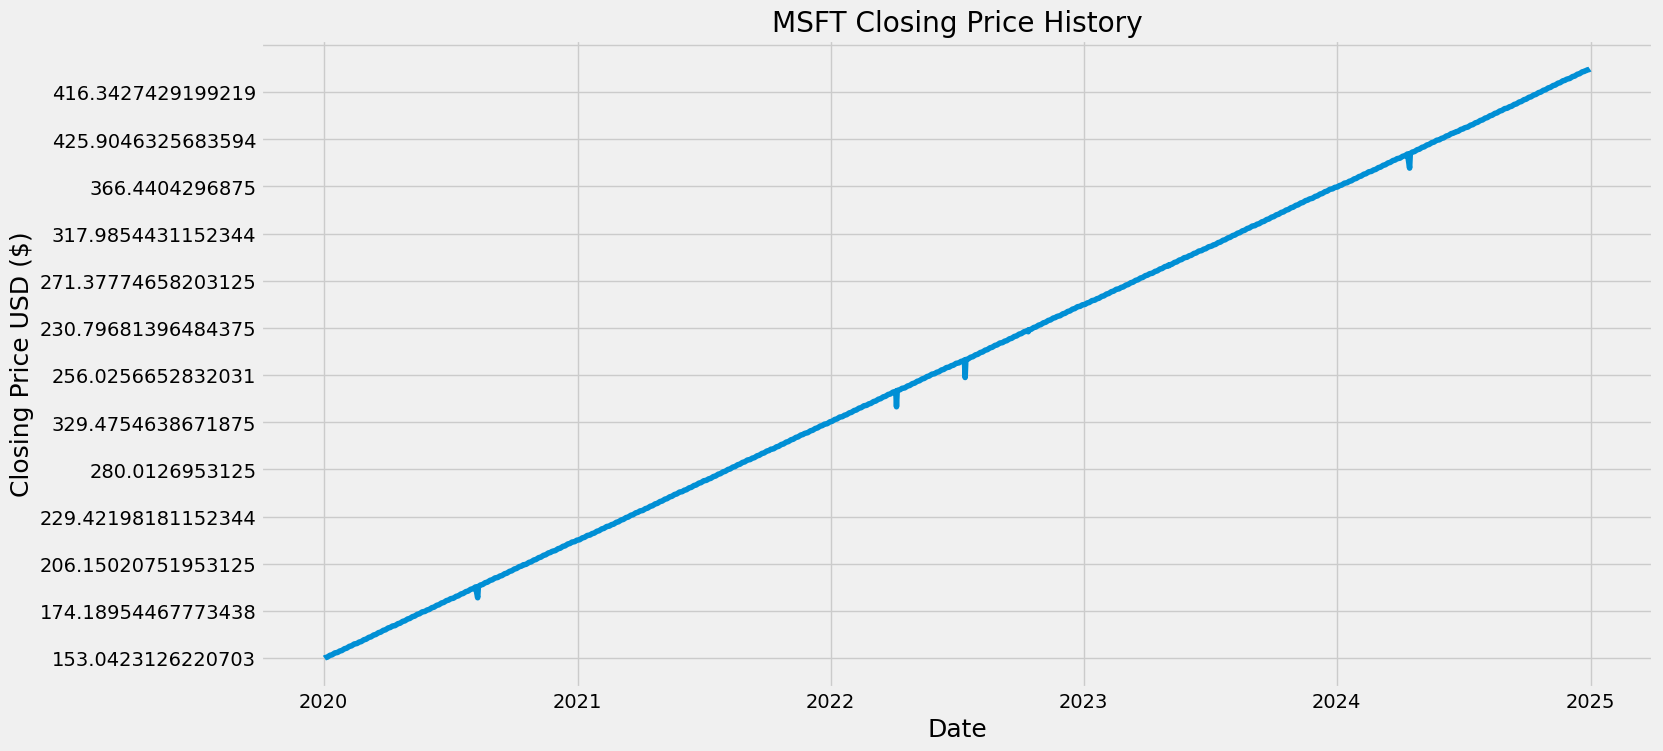

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,8))
plt.title('MSFT Closing Price History')
plt.plot(df['Close'])

# Set axis labels
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# Set y-axis tick spacing to 100
plt.gca().yaxis.set_major_locator(MultipleLocator(100))

plt.grid(True)
plt.show()


### Now we will selct data for a certain time


In [ ]:
from typing import ValuesView
#Create new database with only required columns
data=df.filter(['Close'])
# Convert the dataframe to numpy array
dataset=data.values
# get the number of rows to train 80%
training_data_len=math.ceil(len(dataset)*.8)
print(training_data_len)

1007


In [ ]:
# Scale the data
scaler=StandardScaler()
scaled_data=scaler.fit_transform(dataset)
print('Mean of Processed Data : ',scaled_data.mean())
print('Standard Deviation of Processed Data : ',scaled_data.std())



Mean of Processed Data :  -9.037109516821625e-17
Standard Deviation of Processed Data :  1.0


### Creating the training data

In [ ]:
# Create the training data
# create scaled training dataset
train_data = scaled_data[0:training_data_len,:]
# Split the data to x_train and y_train
x_train=[]
y_train=[]
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [ ]:
# Converting x_train and y_train data to numpy array

x_train,y_train=np.array(x_train),np.array(y_train)
x_train.shape

(947, 60)

In [ ]:
# Reshaping the data

print("x_train shape before reshaping",x_train.shape)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print("x_train shape after reshaping",x_train.shape)

x_train shape before reshaping (947, 60, 1)
x_train shape after reshaping (947, 60, 1)


### Building model

In [ ]:
# Building model

model=Sequential()
model.add(LSTM(200,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(200,return_sequences=False))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

### Compiling the model

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,601 (1.94 MB)

 Trainable params: 507,601 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model now.

In [ ]:
history = model.fit(x_train,y_train,batch_size=1,epochs=5)

Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 146s 150ms/step - loss: 0.0281
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 199s 147ms/step - loss: 0.0083
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 134s 139ms/step - loss: 0.0064
Epoch 4/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 132s 140ms/step - loss: 0.0062
Epoch 5/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 132s 139ms/step - loss: 0.0104


### We will plot the Loss

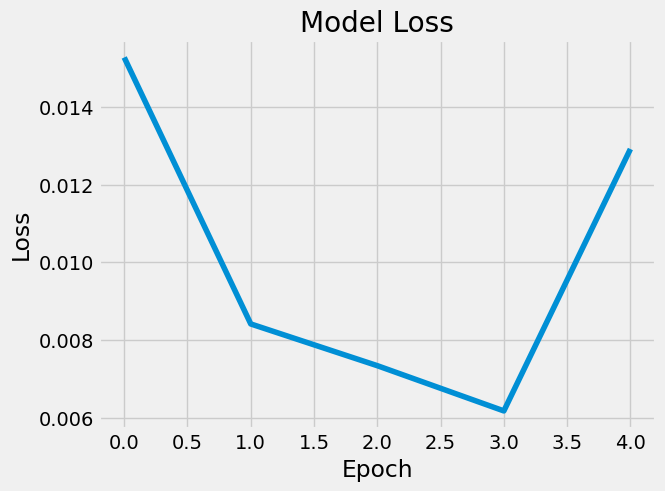

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Creating testing dataset

In [ ]:
# Creating new array
test_data=scaled_data[training_data_len-60:,:]
# Creating the dataset x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [ ]:
# Converting the data to numpy
x_test=np.array(x_test)

In [ ]:
# Reshaping the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
# Getting the model predicted value
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)
print(predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step
[[365.36768]
 [365.12897]
 [362.28784]
 [362.03928]
 [368.16412]
 [369.2419 ]
 [376.19043]
 [378.1869 ]
 [382.23233]
 [384.01456]
 [383.44763]
 [387.2989 ]
 [391.3955 ]
 [389.68524]
 [391.98096]
 [395.03894]
 [397.21344]
 [396.59332]
 [401.79623]
 [400.81924]
 [391.18143]
 [396.21072]
 [402.04355]
 [397.67215]
 [397.96066]
 [405.27332]
 [405.60825]
 [411.89   ]
 [407.531  ]
 [399.6697 ]
 [402.2831 ]
 [398.89444]
 [396.65924]
 [395.3032 ]
 [394.6682 ]
 [403.11945]
 [402.44952]
 [400.77008]
 [400.66522]
 [400.61594]
 [405.7276 ]
 [407.5454 ]
 [407.5241 ]
 [396.66373]
 [395.60336]
 [400.81946]
 [398.27057]
 [397.25247]
 [406.77444]
 [407.06735]
 [416.84857]
 [409.65466]
 [410.6619 ]
 [413.4796 ]
 [416.75153]
 [420.6716 ]
 [420.57004]
 [415.58008]
 [414.02585]
 [413.1322 ]
 [412.2058 ]
 [415.51852]
 [412.9984 ]
 [412.37585]
 [409.94788]
 [416.5176 ]
 [415.91663]
 [417.956  ]
 [415.40607]
 [419.4535 ]
 [414.06192]
 [406.61765]
 [406.5925 ]
 [403.50705]